In [24]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
import kornia.augmentation as K
from tqdm import tqdm

class SimCLR(nn.Module):
    def __init__(self, encoder, training_dataset, isomorphism, image_h, image_w, epochs=10, temperature = 0.5):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.encoder = encoder.to(self.device)
        self.training_dataset = training_dataset
        self.isomorphism = isomorphism if isomorphism is not None else nn.Identity()
        self.loss_fn = torch.nn.functional.cross_entropy
        self.normalize = lambda z: torch.nn.functional.normalize(z, p=2.0, dim=-1, eps=1e-12, out=None)
        self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=1e-4)
        self.T1 = K.RandomRotation(degrees=30, p=1.0).to(self.device)
        self.T2 = K.RandomResizedCrop((image_h, image_w), scale=(0.2, 0.8), p=1.0).to(self.device)
        self.epochs = epochs
        self.temperature = temperature
        
        print(f"Using device: {self.device}")
        
    def loss(self, embeddings):
        N = embeddings.shape[0] // 2
        z_norm = self.normalize(embeddings)
        sim_matrix = z_norm @ z_norm.T / self.temperature

        mask = torch.eye(embeddings.shape[0], device=embeddings.device).bool()
        sim_matrix.masked_fill_(mask, -10e15) # Mask out the diagonal for the InfoNCE loss

        # Prepare the ground-truth labels for the cross-entropy loss
        # i'th element for i < N corresponds to the sample from i + N in the second "batch"
        gt = torch.cat(
            (
                torch.arange(N, embeddings.shape[0]),
                torch.arange(0, N)
            ), dim=0
        ).to(embeddings.device)
        
        return torch.nn.functional.cross_entropy(sim_matrix, gt)
        
    def training_step(self, batch):
        self.optimizer.zero_grad()
        
        x = self.T1(batch)
        x_sim = self.T2(batch)
        x_all = torch.cat((x, x_sim), dim=0)
        z_all = self.encoder(x_all)
        
        l = self.loss(z_all)
        l.backward()
        self.optimizer.step()
        
        return l.item()  # Return scalar value
        
    def train(self):
        self.encoder.train()
        losses = []
        epoch_losses = []
        print('Starting training')
        
        global_step = 0
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            batch_count = 0
            
            # Use tqdm for progress bar
            pbar = tqdm(self.training_dataset, desc=f"Epoch {epoch+1}/{self.epochs}")
            
            for batch in pbar:
                images, _ = batch
                images = images.to(self.device)
                
                loss = self.training_step(self.isomorphism(images))  # Apply isomorphism
                losses.append(loss)
                epoch_loss += loss
                batch_count += 1
                global_step += 1
                
                # Print every 100 iterations
                if global_step % 100 == 0:
                    print(f'Iteration {global_step}, Loss: {loss:.4f}')
                
                # Update progress bar
                pbar.set_postfix({'loss': f"{loss:.4f}"})
            
            # Calculate average loss for the epoch
            avg_epoch_loss = epoch_loss / batch_count
            epoch_losses.append(avg_epoch_loss)
            print(f'Epoch {epoch+1}/{self.epochs}, Average Loss: {avg_epoch_loss:.4f}')
        
        self.encoder.eval()
        
        # Return the trained encoder and the loss history
        return self.encoder, {'batch_losses': losses, 'epoch_losses': epoch_losses}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Files already downloaded and verified


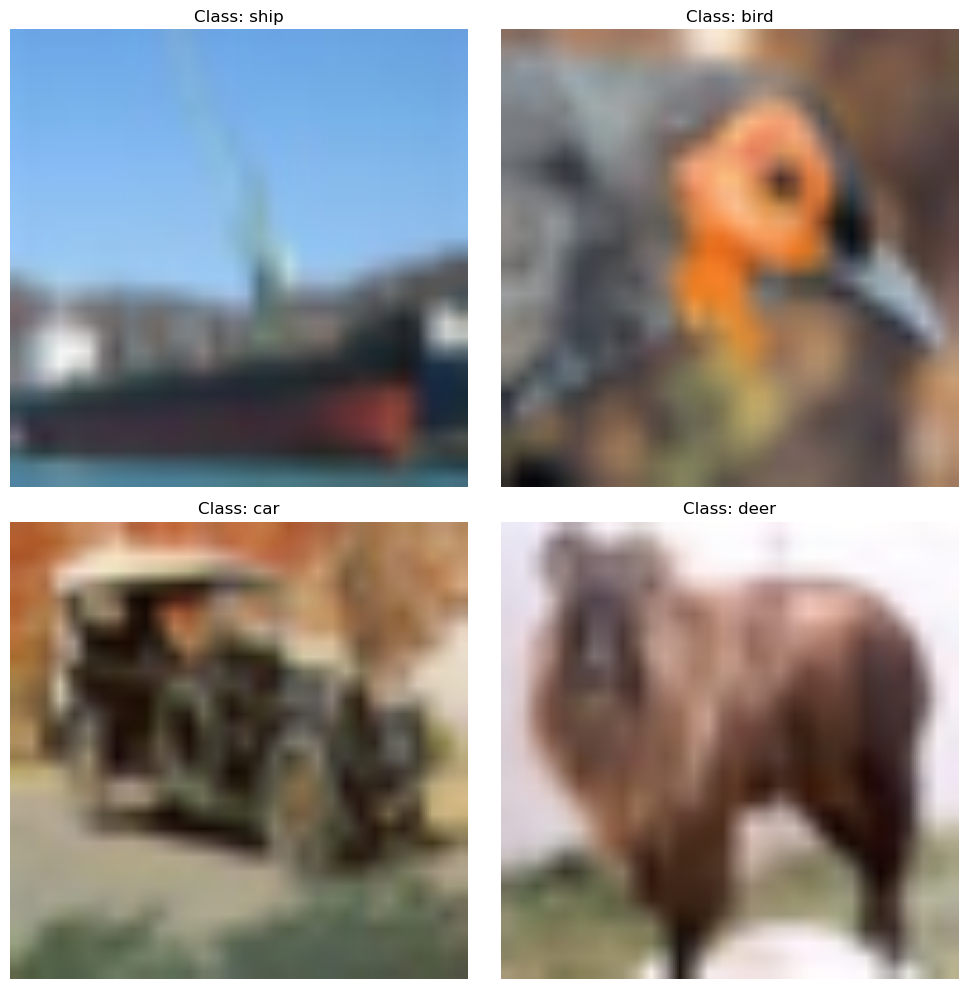

In [3]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Transformation: resize + convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Function to convert tensor to numpy image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # C x H x W -> H x W x C
    return img

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create a figure to display images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    img = imshow(images[i])
    axes[i].imshow(img)
    axes[i].set_title(f'Class: {classes[labels[i]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

/home/justinas/miniconda3/envs/cl_theory/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/justinas/miniconda3/envs/cl_theory/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using device: cuda
Starting training


Epoch 1/2:  20%|█████████████████████████████▊                                                                                                                       | 100/500 [00:30<02:02,  3.28it/s, loss=4.4903]

Iteration 100, Loss: 4.4903


Epoch 1/2:  40%|███████████████████████████████████████████████████████████▌                                                                                         | 200/500 [01:01<01:32,  3.26it/s, loss=4.4139]

Iteration 200, Loss: 4.4139


Epoch 1/2:  60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 300/500 [01:32<01:02,  3.21it/s, loss=4.4155]

Iteration 300, Loss: 4.4155


Epoch 1/2:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 400/500 [02:04<00:31,  3.14it/s, loss=4.3884]

Iteration 400, Loss: 4.3884


Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:36<00:00,  3.20it/s, loss=4.3879]


Iteration 500, Loss: 4.3879
Epoch 1/2, Average Loss: 4.4600


Epoch 2/2:  20%|█████████████████████████████▊                                                                                                                       | 100/500 [00:31<02:06,  3.16it/s, loss=4.3819]

Iteration 600, Loss: 4.3819


Epoch 2/2:  40%|███████████████████████████████████████████████████████████▌                                                                                         | 200/500 [01:03<01:34,  3.18it/s, loss=4.3921]

Iteration 700, Loss: 4.3921


Epoch 2/2:  60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 300/500 [01:35<01:03,  3.16it/s, loss=4.3869]

Iteration 800, Loss: 4.3869


Epoch 2/2:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 400/500 [02:06<00:31,  3.19it/s, loss=4.3759]

Iteration 900, Loss: 4.3759


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:38<00:00,  3.16it/s, loss=4.3755]

Iteration 1000, Loss: 4.3755
Epoch 2/2, Average Loss: 4.3866


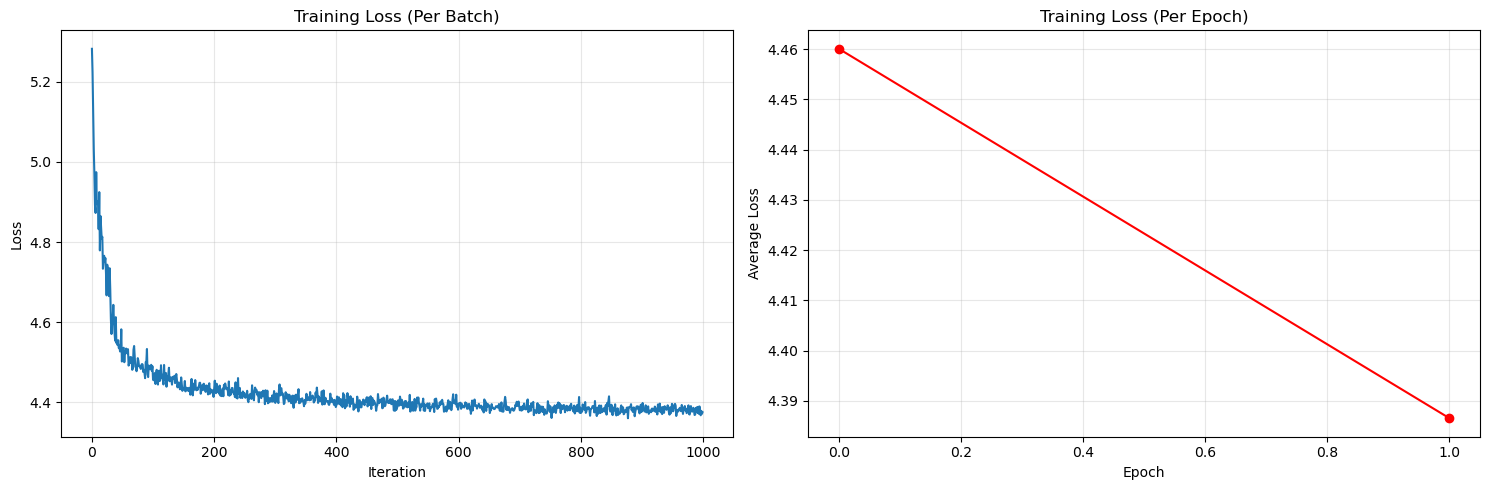

Final training loss: 4.3866


<Figure size 640x480 with 0 Axes>

In [4]:
import torchvision.models as models
import matplotlib.pyplot as plt

# Load non-pretrained ResNet50 and train with SimCLR
resnet50 = models.resnet50(pretrained=False)
trained_resnet50_identity, losses = SimCLR(resnet50, train_loader, nn.Identity(), 224, 224, epochs=2).train()

# Create a figure for plotting the losses
plt.figure(figsize=(15, 5))

# Plot batch losses
plt.subplot(1, 2, 1)
plt.plot(losses['batch_losses'])
plt.title('Training Loss (Per Batch)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot epoch losses
plt.subplot(1, 2, 2)
plt.plot(losses['epoch_losses'], 'ro-')
plt.title('Training Loss (Per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plots if needed
plt.savefig('simclr_training_losses.png', dpi=300, bbox_inches='tight')

print(f"Final training loss: {losses['epoch_losses'][-1]:.4f}")

In [19]:
# Latent Space Evaluation tools

class LinearProbeEvaluator(nn.Module):
    def __init__(self, encoder, embedding_dim, num_classes, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Freeze encoder weights
        self.encoder = encoder.to(self.device).eval()
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Projects from the latent space into the classification space
        self.classifier = nn.Linear(embedding_dim, num_classes).to(self.device)
        # Loss for classification
        self.loss_fn = nn.CrossEntropyLoss()

        # Optimizer for training the linear encoder
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

    def train_probe(self, train_loader: DataLoader, val_loader: DataLoader = None, epochs: int = 10):
        self.classifier.train()
        print("Starting linear probe training...")

        for epoch in range(epochs):
            total_loss = 0.0
            correct = 0
            total = 0

            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
            for x, y in pbar:
                x, y = x.to(self.device), y.to(self.device)

                # Making sure no gradient is calculated here
                with torch.no_grad():
                    z = self.encoder(x)

                # Get logits
                preds = self.classifier(z)

                # Compute the cross-entropy loss on the logits
                loss = self.loss_fn(preds, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                
                total_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)

                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(correct / total) * 100:.2f}%'})

            avg_loss = total_loss / len(train_loader)
            acc = correct / total * 100
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

            if val_loader:
                self.evaluate(val_loader)

    def evaluate(self, dataloader: DataLoader):
        self.classifier.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                z = self.encoder(x)
                preds = self.classifier(z)
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)

        acc = correct / total * 100
        print(f"[Validation] Accuracy: {acc:.2f}%")
        self.classifier.train()
        return acc

In [23]:
# Latent Space Evaluation

lin_epochs = 3

im, c = next(iter(train_loader))

test_input_shape = trained_resnet50_identity(im[0].unsqueeze(0).to('cuda')).shape

resnet_linear_proble = LinearProbeEvaluator(trained_resnet50_identity, test_input_shape[-1], 10, device='cuda' if torch.cuda.is_available() else 'cpu')

valset = CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(valset, batch_size=100, shuffle=True, num_workers=2)

resnet_linear_proble.train_probe(train_loader, val_loader, 10)


Files already downloaded and verified
Starting linear probe training...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.21it/s, loss=2.0103, acc=28.54%]

Epoch 1: Loss = 1.9603, Accuracy = 28.54%


[Validation] Accuracy: 31.71%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.16it/s, loss=1.8503, acc=31.08%]


Epoch 2: Loss = 1.8914, Accuracy = 31.08%
[Validation] Accuracy: 31.90%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.18it/s, loss=1.8271, acc=32.73%]

Epoch 3: Loss = 1.8630, Accuracy = 32.73%


[Validation] Accuracy: 34.12%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.10it/s, loss=2.0524, acc=34.05%]

Epoch 4: Loss = 1.8325, Accuracy = 34.05%


[Validation] Accuracy: 34.37%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.16it/s, loss=1.6910, acc=34.94%]

Epoch 5: Loss = 1.8090, Accuracy = 34.94%


[Validation] Accuracy: 34.24%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.04it/s, loss=1.8313, acc=35.53%]


Epoch 6: Loss = 1.7958, Accuracy = 35.53%
[Validation] Accuracy: 35.08%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.04it/s, loss=2.0231, acc=36.00%]

Epoch 7: Loss = 1.7864, Accuracy = 36.00%


[Validation] Accuracy: 35.78%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.09it/s, loss=1.7561, acc=36.47%]


Epoch 8: Loss = 1.7671, Accuracy = 36.47%
[Validation] Accuracy: 36.13%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.92it/s, loss=1.5796, acc=37.20%]


Epoch 9: Loss = 1.7564, Accuracy = 37.20%
[Validation] Accuracy: 37.32%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.97it/s, loss=1.7236, acc=37.32%]


Epoch 10: Loss = 1.7522, Accuracy = 37.32%
[Validation] Accuracy: 37.51%


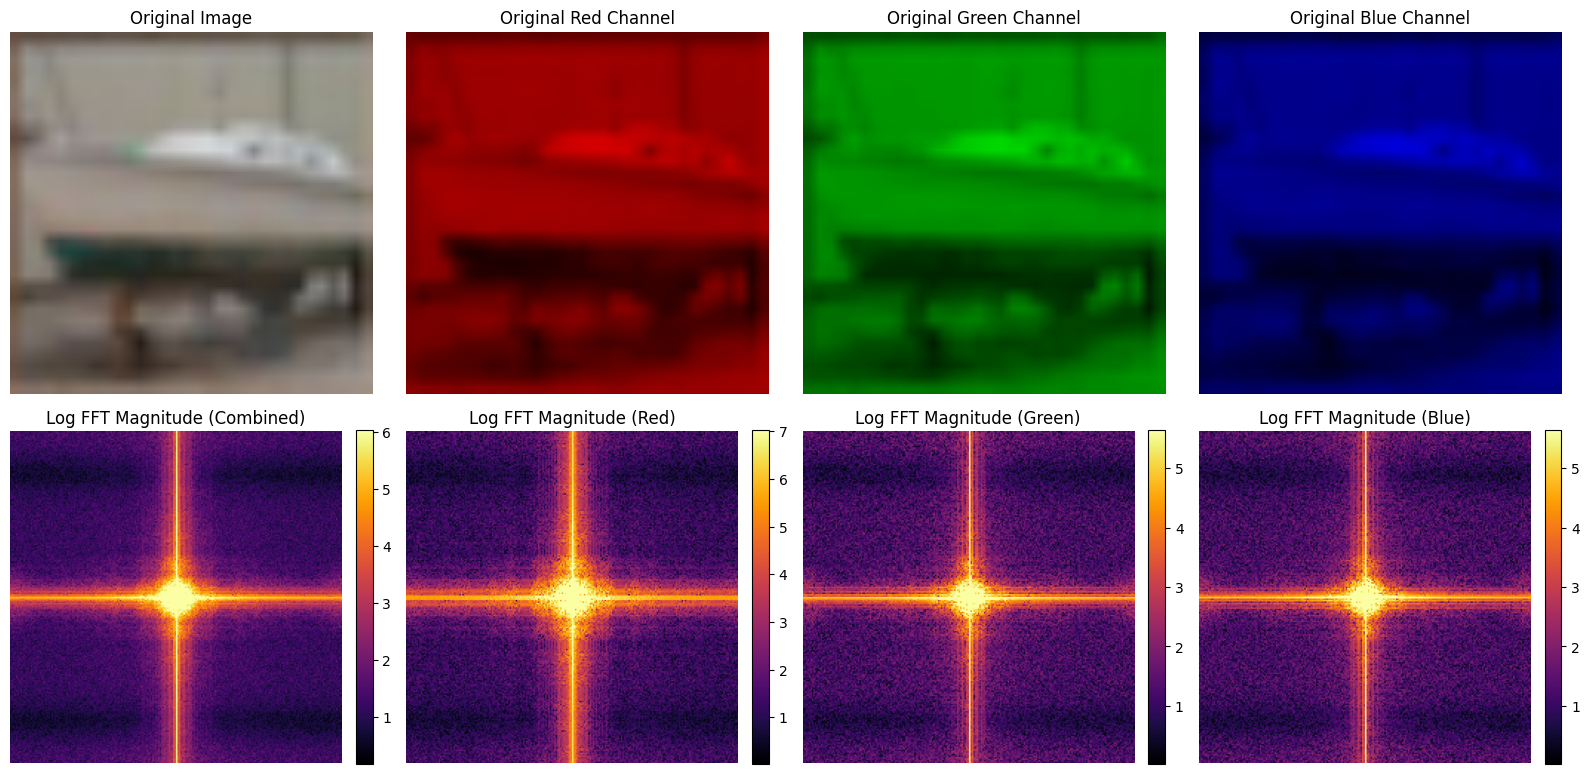

In [216]:
# Visualize the dataset after fourier transform

from torch.fft import fftn, fftshift
import torch
import matplotlib.pyplot as plt
import numpy as np

images_fft = fftn(images)

def visualize_fft_improved(images, images_fft, index=0):
    # Get the original image and its FFT result
    image = images[index]
    fft_result = images_fft[index]
    
    # For visualization, we need to use fftshift to center the zero frequency component
    fft_shifted = fftshift(fft_result, dim=(-2, -1))
    
    # Calculate the magnitude spectrum with logarithmic scaling for better visualization
    # log(1+x) helps to enhance the visibility of details
    magnitude_spectrum = torch.log1p(torch.abs(fft_shifted))
    
    # Move tensors to CPU and convert to numpy for plotting
    image_np = image.cpu().permute(1, 2, 0).numpy()
    
    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Show original image
    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Show each channel separately
    for i in range(3):
        channel_name = ['Red', 'Green', 'Blue'][i]
        
        # Original channel
        single_channel = np.zeros_like(image_np)
        single_channel[:, :, i] = image_np[:, :, i]
        axes[0, i+1].imshow(single_channel)
        axes[0, i+1].set_title(f'Original {channel_name} Channel')
        axes[0, i+1].axis('off')
        
        # FFT magnitude for this channel
        mag_channel = magnitude_spectrum[i].cpu().numpy()
        
        # Clip values for better color distribution (adjusting as needed)
        # This helps to highlight patterns that might be hidden otherwise
        vmax = np.percentile(mag_channel, 99)  # Use 99th percentile as max to ignore outliers
        
        im = axes[1, i+1].imshow(mag_channel, cmap='inferno', vmax=vmax)
        axes[1, i+1].set_title(f'Log FFT Magnitude ({channel_name})')
        axes[1, i+1].axis('off')
        plt.colorbar(im, ax=axes[1, i+1], fraction=0.046, pad=0.04)
    
    # Show combined FFT magnitude (average across channels)
    combined_mag = torch.mean(magnitude_spectrum, dim=0).cpu().numpy()
    vmax_combined = np.percentile(combined_mag, 99)
    im = axes[1, 0].imshow(combined_mag, cmap='inferno', vmax=vmax_combined)
    axes[1, 0].set_title('Log FFT Magnitude (Combined)')
    axes[1, 0].axis('off')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Call the function
visualize_fft_improved(images, images_fft, index=0)

In [221]:
# Load non-pretrained ResNet50 and train with SimCLR
resnet50 = models.resnet50(pretrained=False)
trained_resnet50_identity, losses = SimCLR(resnet50, train_loader, fftn, 224, 224).train()

Using device: cpu
Starting training


Epoch 1/10:   0%|                                                                                                                                                                            | 0/1000 [00:07<?, ?it/s]


TypeError: Expected input of [torch.float16, torch.float32, torch.float64]. Got torch.complex64